## Summarize the centriole compensation

Required input:

For the midline: a list of X_coordinate and a list of Y_coordinate

For the edge: a list of X_coordinate and a list of Y_coordinate

For the centriole: a list of list containing [X_coordinate, Y_coordinate, an angle (in degrees)]

In [1]:
import import_ipynb

from tools.Centriole_Characteristic import *
from tools.Extract_Experiment_Characteristic import *
from tools.CNN_Tools import *

importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\Centriole_Characteristic.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\ToolBox.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\Midline_Edge_Reformater.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\Extract_Experiment_Characteristic.ipynb
Compensation_de_l-orientation_des_rootlets_V3-2c_160412_Max-10000-rootlets.xlsm
right
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\CNN_Tools.ipynb


In [2]:
path = './data_excel_example/150518_Smed-Unc22_Rootletin_100x-1(V3-2c).xlsm'

db = get_xls_values(path)

x_mid = db['worm_midline']['x']
y_mid = db['worm_midline']['y']
x_edg = db['worm_edge']['x']
y_edg = db['worm_edge']['y']

./data_excel_example/150518_Smed-Unc22_Rootletin_100x-1(V3-2c).xlsm


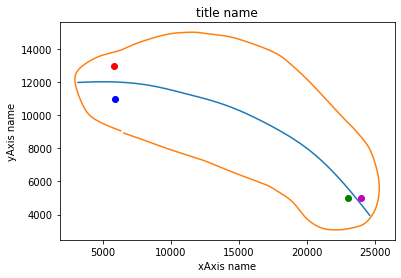

In [3]:
import matplotlib.pyplot as plt

plt.plot(x_mid,y_mid)
plt.plot(x_edg,y_edg)
plt.plot(5800, 13000, 'ro')
plt.plot(5900, 11000, 'bo')
plt.plot(23000, 5000, 'go')
plt.plot(24000, 5000, 'mo')

plt.title('title name')
plt.xlabel('xAxis name')
plt.ylabel('yAxis name')
plt.show()

In [4]:
# From a midline and an edge, give as output
midline_final = aggregate_segment_char(x_mid, y_mid, 
                                       x_edg, y_edg, 
                                       n_midline_seg = 50, 
                                       n_sub_segment = 25, 
                                       n_edge_seg = 200)

In [5]:
a_list_of_centriole = [((5800, 13000), 50), ((5900, 11000), 50), ((23000, 5000), 50), ((24000, 5000), 50)]
test = []

for a_centriole in a_list_of_centriole:
    test.append(centriole_characterizator(a_centriole, midline_final))
     

In [6]:
for i in test:
    print(i)
    print('\n')

(5, 988.2075828106671, 216.9760961981248, 'left', 0.563472917616304, 0.10959088254602381, 41.51061351519587)


(6, 1009.863618162006, 74.33600752991232, 'right', 0.35727083961444134, 0.12304100574886619, 42.48020547116511)


(46, 433.56382325998896, 54.28058295473339, 'right', 0.14195996096928423, 0.9204938207608431, 84.83872559598734)


(48, 272.74663981600247, 194.71604515002582, 'left', 0.14405801326528786, 0.9666224593001325, 86.18013195890816)




+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [15]:
a_segment_list = midline_final
lateral_dist = 20


print(a_segment_list[-1][4]+a_segment_list[-1][3])

test = []
[test.append(ele[3]) for ele in a_segment_list]
print(sum(test))



23675.585014847267
23675.585014847267


In [17]:
midline_final[0][4]

0

[3, (4610.852713178295, 12019.536434108526), (5075.299224806202, 12022.446511627906), 464.45562835915814, 1431.4258223829775, 89.64100714754179, 0.006265689259200545, 11990.646263787808, [(0.0, [['left', 1490.0661189557466], ['right', 2361.208490827175]]), (18.578225134366324, [['left', 1496.8978961586495], ['right', 2369.5916705454015]]), (37.15645026873265, [['left', 1503.7296733615522], ['right', 2377.9748502636294]]), (55.734675403098976, [['left', 1509.6844298781089], ['right', 2386.358029981854]]), (74.3129005374653, [['left', 1515.50381522966], ['right', 2394.7412097000824]]), (92.89112567183162, [['left', 1521.3232005812113], ['right', 2403.1243894183085]]), (111.46935080619795, [['left', 1527.1425859327624], ['right', 2411.507569136537]]), (130.04757594056426, [['left', 1532.9619712843155], ['right', 2419.890748854761]]), (148.6258010749306, [['left', 1538.7813566358684], ['right', 2428.2739285729895]]), (167.20402620929693, [['left', 1544.6007419874197], ['right', 2436.657108

In [11]:
if a_segment_list[seg_index][-1][idx_sub_seg][1][1][0] == centr_side:
    lateral_rel = lateral_dist/(a_segment_list[-1][idx_sub_seg][1][0])

(19.56019771255934,
 [['right', 3620.6123326333714], ['left', 3965.697109557691]])

In [ ]:
point_a = (5800, 13000)
point_b = midline_final[5][1]
point_c = midline_final[5][2]
point_d = (point_b, point_c)

print(point_d)

In [8]:
a_segment_list = midline_final

In [17]:
sub_list = []
[sub_list.append(ele[0]) for ele in a_segment_list[20][-1]]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [15]:
sub_list

[470.40227115026005,
 475.44866810987236,
 485.5748831228449,
 464.45562835915814,
 481.77070963026773,
 461.07962401727684,
 473.060202124893,
 480.92890399358737,
 444.28598072492605,
 484.6719957134738,
 480.81844476716617,
 474.4929097862398,
 469.7091897902134,
 467.051493633911,
 466.4151426059062,
 467.7089929796697,
 470.8880595299642,
 475.48832645695927,
 480.1551649157687,
 484.6408598670779,
 489.0049428139835,
 452.05900648281346,
 455.7580625808777,
 501.57163575038254,
 463.69407857173957,
 467.1105530568921,
 470.14000731098537,
 472.73297187286147,
 474.84875823837814,
 476.44816203854924,
 477.5038976499522,
 478.1539793135855,
 478.57402896087393,
 478.8518300724657,
 435.5277147059948,
 479.37665128502994,
 479.8938149981275,
 480.77332266046244,
 481.5449843959298,
 480.5268982042997,
 434.1150953046854,
 472.33417065792366,
 506.2570144810371,
 453.02169524692897,
 478.93882866025945,
 461.1395695157412,
 482.56337153541085,
 469.12366962540057,
 984.948847576261]

In [15]:



index = 0
dist = 99999999999999999999999

# find the segment closest to a point + return some characteristics
for segment in a_segment_list:
    new_dist, new_lateral_dist, new_long_dist, new_centr_side = distance_point_segment(a_centriole_coord, segment[1], segment[2])

    if new_dist <= dist:
        seg_index = segment[0]
        dist, lateral_dist, long_dist, centr_side = new_dist, new_lateral_dist, new_long_dist, new_centr_side 

# COMPUTE THE RELATIVE LATERAL DISTANCE
# get the relative distance (longitudinal distance - total segment distance)
sub_seg_dist = long_dist - a_segment_list[seg_index][4]

# create length list for sub_segmen
sub_list = []
print('là')
[sub_list.append(ele[0]) for ele in a_segment_list[-1]]
print('oulla')
# search in the list the closest to sub_seg_dist
idx_sub_seg = min(range(len(sub_list)), key=lambda x:abs(sub_list[x]-sub_seg_dist[1]))
print('oulala')
if a_segment_list[-1][idx_sub_seg][1][1] == centr_side:
    lateral_rel = lateral_dist/a_segment_list[-1][idx_sub_reg][1][0]

else: 
    lateral_rel = lateral_dist/a_segment_list[-1][idx_sub_reg][2][0]

print('ouencorela')
# COMPUTE RELATIVE LONGITUDINAL DISTANCE
worm_length = [sum(ele[3]) for ele in a_segment_list]

longitudinal_rel = longitudinal_dist/worm_length

print('oulala')
# COMPUTE NEW ANGLE
newAngle = a_centriole_coord[2] - a_segment_list[seg_index][5]


In [16]:
centr_side

'left'

In [11]:
slope_origin = get_segment_slope_and_origin((point_b, point_c))
proj_a_on_bc = orthogonal_projection(point_a, slope_origin[0], slope_origin[1])


#proj_a_to_b = segment_length(proj_a_on_bc, point_b)
#proj_a_to_c = segment_length(proj_a_on_bc, point_b)
#b_to_c = segment_length(point_b, point_c)
    

NameError: name 'point_b' is not defined

In [13]:
output = []
segments_coordinates = point_d


for i in range(len(segments_coordinates)-1):
    a = slope(segments_coordinates[i], segments_coordinates[i+1])
    b = origin(segments_coordinates[i], a)

    output.append((a, b))


In [15]:
a, b = output

ValueError: not enough values to unpack (expected 2, got 1)

In [12]:
for a_segment in midline_final:
    print(a_segment[1], a_segment[2])

(3180.0000000000005, 11980.0) (3650.125581395349, 11996.131782945737)
(3650.125581395349, 11996.131782945737) (4125.370542635659, 12010.048062015503)
(4125.370542635659, 12010.048062015503) (4610.852713178295, 12019.536434108526)
(4610.852713178295, 12019.536434108526) (5075.299224806202, 12022.446511627906)
(5075.299224806202, 12022.446511627906) (5557.048062015503, 12017.855813953487)
(5557.048062015503, 12017.855813953487) (6017.9674418604645, 12005.700775193798)
(6017.9674418604645, 12005.700775193798) (6490.58449612403, 11985.229457364341)
(6490.58449612403, 11985.229457364341) (6970.612403100775, 11955.80465116279)
(6970.612403100775, 11955.80465116279) (7413.486821705425, 11920.417054263566)
(7413.486821705425, 11920.417054263566) (7895.737984496124, 11872.035658914729)
(7895.737984496124, 11872.035658914729) (8372.897674418606, 11812.832558139535)
(8372.897674418606, 11812.832558139535) (8842.186046511628, 11742.747286821705)
(8842.186046511628, 11742.747286821705) (9305.144186